In [1]:
import pandas as pd
import osmnx as ox
import networkx as nx 
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from pyproj import Proj, transform


import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import dotmap
import sys
import random
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]

import seaborn as sns
import scienceplots
import matplotlib.patches as mpatches
from cycler import cycler
cwd = os.getcwd()
from ExMAS.utils import inData as inData
from dotmap import DotMap

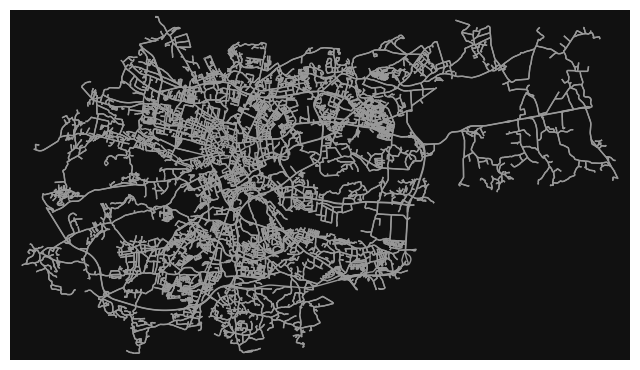

In [2]:
G = ox.load_graphml('ExMAS/data/graphs/Krakow.graphml')
fig, ax = ox.plot_graph(G, node_size=0)

<AxesSubplot: >

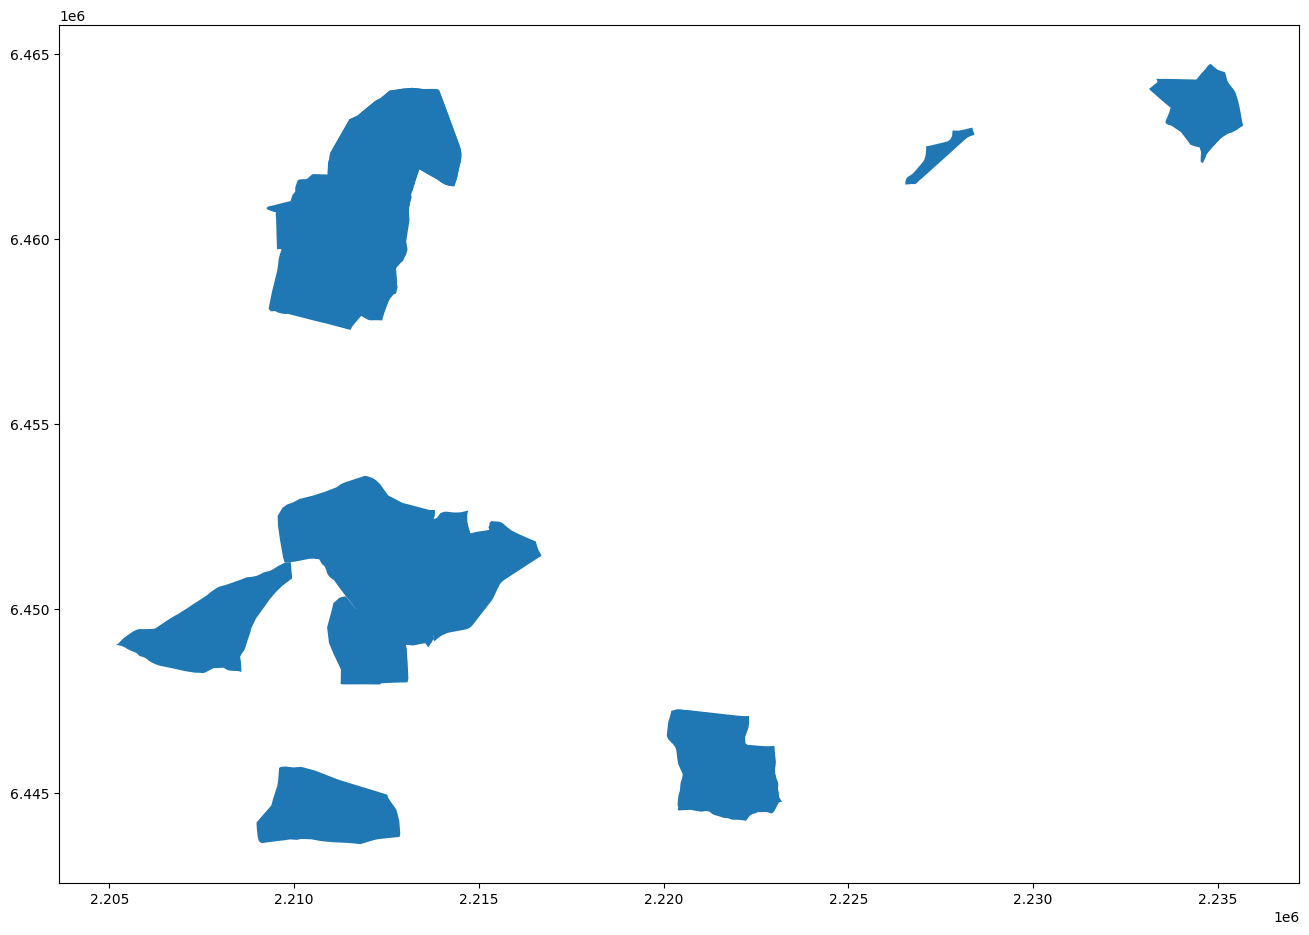

In [3]:
shapefile_path = 'Obszary_SUM.shp' # Replace 'name.shp' with the actual name of your shapefile
gdf = gpd.read_file(shapefile_path) # Read the shapefile
geometries = gdf['geometry'] # Extract the geometries
gdf.plot()


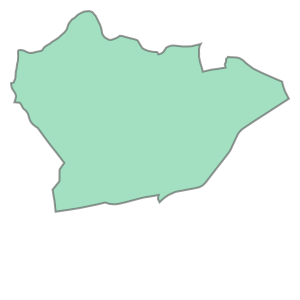

In [4]:
geometries[1]

In [5]:
polygon = gdf['geometry'].iloc[1]
source_crs = Proj(init='epsg:3857') # Conver the CRS
target_crs = Proj(init='epsg:4326')

x, y = polygon.exterior.xy
lon, lat = transform(source_crs, target_crs, x, y)

converted_polygon = Polygon(zip(lon, lat))

df = pd.read_csv('demografia_KRK.csv') # all locations

# add another column to the df: True means the location is inside the target polygon and False means is not.
df['inside_polygon'] = df.apply(lambda row: True if converted_polygon.contains(Point(row.x, row.y)) else False, axis=1) 
df1 = df[df.inside_polygon==True] # filter the points which are inside the polygon
df1.tail(1)

,FID,x,y,adr_pelny,ogolem,inside_polygon
47669,47669,19.8795,50.024526,SKOTNICKA 22,1,True


In [6]:
df = df1.loc[df1.index.repeat(df1.ogolem)].reset_index(drop=True) #repeat Rows N times (equal "ogolem"): N Rows = N people 
params = ExMAS.utils.get_config('default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [7]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['y'], row['x'])), axis = 1) 
    inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests

    my_requests = inData.requests
    my_requests.destination = hub[1]
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1)
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests = inData.requests
    inData.requests = my_requests
    inData = ExMAS.main(inData, params)
    KPIs = inData.sblts.res.to_frame()[:23]
    KPIs.columns = ['KPI']
    KPIs
    KPIs.to_csv(f'res/1/KPI_{hub[0]}_{frac}_{repl}.csv') #res/
    return KPIs
results = dict()
 
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844, 19.88948])), 
        ('hub2', ox.get_nearest_node(inData.G,[50.030129, 19.913131]))]

for frac in  [0.001]: #list of frac 0.001, 0.002, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.05
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 0.001 1
13-11-24 12:49:02-INFO-Initializing pairwise trip shareability between 4 and 4 trips.
13-11-24 12:49:02-INFO-creating combinations
13-11-24 12:49:02-INFO-12	 nR*(nR-1)
13-11-24 12:49:02-INFO-Degree 2 	Completed
13-11-24 12:49:02-INFO-No more trips to exted at degree 2
13-11-24 12:49:02-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
13-11-24 12:49:02-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,043 
reduced by matching to:                2,043
13-11-24 12:49:02-INFO-Calculations  completed
13-11-24 12:49:02-INFO-DotMap(VehHourTrav=2043, VehHourTrav_ns=2043, PassHourTrav=2043, PassHourTrav_ns=2043, PassUtility=25.552500000000002, PassUtility_ns=25.552500000000002, mean_lambda=nan, revenue_s=1838.7, revenue_ns=3064.5, Fare_Discount=-0.39999999999999997, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=2.0, fleet_size_shared=2.0, lambda_shared=0)
hub2 0.001 1
13-11-24 12:49:0

In [8]:
results = {}
for num, frac, rep in list(itertools.product([1,2], [0.001, 0.002, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.05], range(10))):
    results[str((num, frac, rep))] = pd.read_csv('res/1/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/1/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["hub"]
# print(dfr)
dfr.to_csv('res/1/result1_D0-05(10).csv')
pd.read_csv('res/1/result1_D0-05(10).csv', header=None).T.to_csv('res/1/resultT1_D0-05(10).csv', header=False, index=False)

In [9]:
dfT = pd.read_csv('res/1/resultT1_D0-05(10).csv', index_col=0) # discount 0.2

dfT['del_VehHourTrav']=abs(dfT['VehHourTrav']-dfT['VehHourTrav_ns'])/dfT['VehHourTrav_ns']           # KPI1: vehicle hours reduction
dfT['del_PassUtility']=abs((dfT['PassUtility']-dfT['PassUtility_ns'])/dfT['PassUtility_ns'])      # KPI2: travellers utility gains
dfT['Occupancy']=dfT['PassHourTrav']/dfT['VehHourTrav']                                       # KPI4: occupancy
dfT['del_PassHourTrav']=abs((dfT['PassHourTrav']-dfT['PassHourTrav_ns'])/dfT['PassHourTrav_ns'])  # KPI5: passenger hours increase
dfT['del_fleet_size']=abs((dfT['fleet_size_shared']-dfT['fleet_size_nonshared'])/dfT['fleet_size_nonshared'])  # KPI6: potential fleet size reduction                  
                  
dfT['frac'] = round((dfT['nR'] / 4550),3) # population of Area3
dfT['VehHourTrav_average'] =dfT['VehHourTrav'] / dfT['nR'] 
dfT['PassHourTrav_average'] =dfT['PassHourTrav'] / dfT['nR'] 

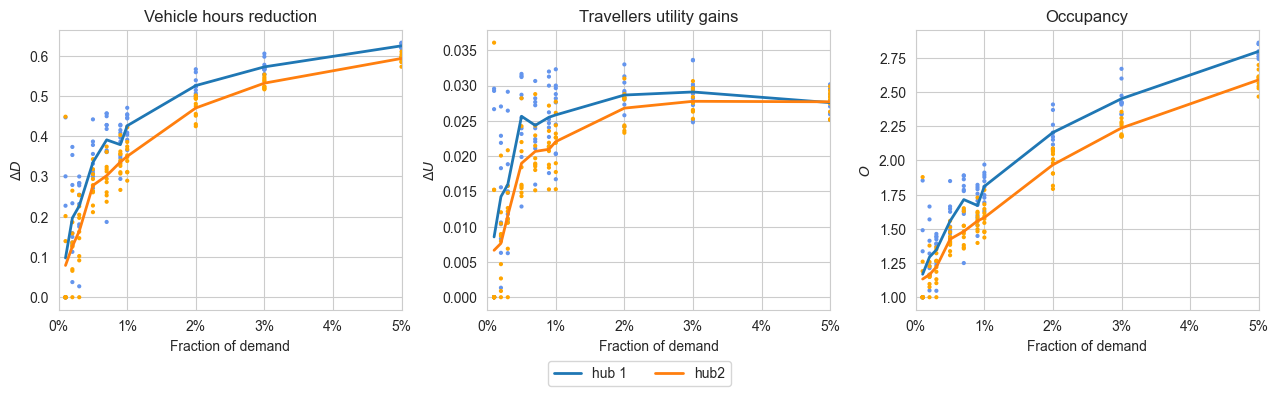

In [12]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1,3, figsize = (12,4))
axes = axes.flatten()

ax=axes[0]
for f in dfT.hub.unique():
    to_plot = dfT[(dfT.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_VehHourTrav'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT[(dfT.hub == f)].groupby(dfT.frac).del_VehHourTrav.mean().plot(ax = ax, label = f, lw = 2)

ax.set_title("Vehicle hours reduction", fontsize=12, fontweight='normal')
ax.set_ylabel("$\Delta D$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0%','1%','2%','3%','4%','5%') )
ax.set_xlim((0,0.05))

ax=axes[1]
for f in dfT.hub.unique():
    to_plot = dfT[(dfT.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_PassUtility'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT[(dfT.hub == f)].groupby(dfT.frac).del_PassUtility.mean().plot(ax = ax, label = f, lw = 2)

ax.set_title("Travellers utility gains", fontsize=12, fontweight='normal')
ax.set_ylabel("$\Delta U$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0%','1%','2%','3%','4%','5%') )
ax.set_xlim((0,0.05))

ax=axes[2]
for f in dfT.hub.unique():
    to_plot = dfT[(dfT.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['Occupancy'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT[(dfT.hub == f)].groupby(dfT.frac).Occupancy.mean().plot(ax = ax, label = f, lw = 2)

ax.set_title("Occupancy", fontsize=12, fontweight='normal')
ax.set_ylabel("$O$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0%','1%','2%','3%','4%','5%') )
ax.set_xlim((0,0.05))

plt.subplots_adjust(left=0,
                    bottom=0.2, 
                    right=1, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.4)

labels = ['hub 1', 'hub2']

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='lower center', ncol=3)
